# Using KGFE to understand important features

Basically, given a list of genes/proteins/metabolites that are mapped onto SPOKE, we want to identify nodes on the graph that are in some way "similar" to the input nodes.

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe

## 1. Load genes

In [2]:
data = pd.read_excel('LC_mets_prots_V1_V2_Compare.xlsx')

In [3]:
data.head()

,ID,Lasso_CV,Name,UniProt,Protein,PubChem,Chembl_ID,KEGG
0,met10,-0.100203,"1,2,4-benzenetriol",NaN,NaN,10787.0,CHEMBL3092389,C02814
1,met1054,-0.052794,pyridine,NaN,NaN,1049.0,CHEMBL266158,C00747
2,met1073,0.051544,uric acid,NaN,NaN,1175.0,CHEMBL792,C00366
3,met1091,-0.054557,formononetin,NaN,NaN,5280378.0,CHEMBL242341,C00858
4,met142,0.025830,4-Hydroxyvalproic acid,NaN,NaN,134467.0,CHEMBL3706504,C16649


In [4]:
data.shape

(92, 8)

In [5]:
data[~data.Chembl_ID.isna()]

,ID,Lasso_CV,Name,UniProt,Protein,PubChem,Chembl_ID,KEGG
0,met10,-0.100203,"1,2,4-benzenetriol",NaN,NaN,10787.0,CHEMBL3092389,C02814
1,met1054,-0.052794,pyridine,NaN,NaN,1049.0,CHEMBL266158,C00747
2,met1073,0.051544,uric acid,NaN,NaN,1175.0,CHEMBL792,C00366
3,met1091,-0.054557,formononetin,NaN,NaN,5280378.0,CHEMBL242341,C00858
4,met142,0.025830,4-Hydroxyvalproic acid,NaN,NaN,134467.0,CHEMBL3706504,C16649
6,met20,-0.045657,"2,6-dihydroxybenzoic acid",NaN,NaN,9338.0,CHEMBL454808,NaN
11,met305,0.035464,hexadecanedioic acid,NaN,NaN,10459.0,CHEMBL4519590,C19615
12,met31,-0.057506,"3,5-dichlorosalicylic acid",NaN,NaN,9445.0,CHEMBL449129,NaN
15,met53,0.033875,benzyldodecyldimethylammonium,NaN,NaN,8754.0,CHEMBL1907001,NaN
18,met675,0.029451,cytidine,NaN,NaN,596.0,CHEMBL78,NaN


## 2. Load SPOKE

In [6]:
import igraph as ig

In [7]:
spoke_graph = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2021.jsonl.gz', directed=True,
                                                    verbose=False)

In [8]:
spoke_graph_ud = spoke_graph.copy()
spoke_graph_ud.to_undirected(combine_edges='first')
spoke_graph_ud.simplify(combine_edges='first')

In [9]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud)

### Load smaller versions of spoke

In [10]:
spoke_level1_graph = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2021_b_biological_objects.jsonl.gz',
                                                         directed=True,
                                                         verbose=False)

In [11]:
spoke_level1_graph_ud = spoke_level1_graph.copy()
spoke_level1_graph_ud.to_undirected(combine_edges='first')
spoke_level1_graph_ud.simplify(combine_edges='first')

### Map proteins and metabolites to SPOKE nodes

In [12]:
len(names_to_ids)

617546

In [13]:
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Protein')

In [14]:
chembl_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Compound')

In [15]:
high_prots = data[(data['Lasso_CV'] > 0) & (~data['UniProt'].isna())]['UniProt']
low_prots = data[(data['Lasso_CV'] < 0) & (~data['UniProt'].isna())]['UniProt']
high_chems = data[(data['Lasso_CV'] > 0) & (~data['Chembl_ID'].isna())]['Chembl_ID']
low_chems = data[(data['Lasso_CV'] < 0) & (~data['Chembl_ID'].isna())]['Chembl_ID']

In [16]:
high_prots_spoke_ids = [uniprot_to_ids[x] for x in high_prots]
low_prots_spoke_ids = [uniprot_to_ids[x] for x in low_prots]

In [17]:
high_prots_spoke_ids[:10]

['2117820',
 '2117949',
 '2117754',
 '2146526',
 '2117892',
 '2119494',
 '2117761',
 '2118204',
 '2118205',
 '2149119']

In [18]:
high_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in high_chems if  x in chembl_to_ids]
low_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in low_chems if  x in chembl_to_ids]

Note: many chems were not able to be mapped onto SPOKE.

In [19]:
high_chems_spoke_ids

[('CHEMBL792', '1282230'),
 ('CHEMBL78', '268338'),
 ('CHEMBL1236395', '1497509'),
 ('CHEMBL8165', '759937'),
 ('CHEMBL1226', '1551766')]

In [20]:
low_chems_spoke_ids

[('CHEMBL3092389', '1051506'),
 ('CHEMBL266158', '1529834'),
 ('CHEMBL242341', '440588'),
 ('CHEMBL454808', '1168062'),
 ('CHEMBL449129', '1175855'),
 ('CHEMBL228057', '5555'),
 ('CHEMBL366563', '930796'),
 ('CHEMBL1256480', '1328370'),
 ('CHEMBL394875', '1843928')]

### TODO: Compare the identified nodes against a null model.

In [21]:
spoke_graph_ud_connected = spoke_graph_ud.subcomponent(high_prots_spoke_ids[0])
spoke_graph_ud_connected = spoke_graph_ud.induced_subgraph(spoke_graph_ud_connected)

In [22]:
len(high_prots_spoke_ids)

31

In [24]:
len(low_prots_spoke_ids)

23

In [23]:
%prun high_prots_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, high_prots_spoke_ids)

         1046 function calls in 1.164 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       30    1.163    0.039    1.163    0.039 {method 'get_shortest_paths' of 'igraph._igraph.GraphBase' objects}
        1    0.001    0.001    1.164    1.164 explanations.py:101(graph_node_stats)
        1    0.000    0.000    1.164    1.164 {built-in method builtins.exec}
      495    0.000    0.000    0.000    0.000 explanations.py:124(<genexpr>)
       30    0.000    0.000    0.000    0.000 {method 'extend' of 'list' objects}
      466    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 functools.py:35(update_wrapper)
        1    0.000    0.000    0.000    0.000 functools.py:479(lru_cache)
        1    0.000    0.000    0.000    0.000 explanations.py:79(create_shortest_path_lengths_cached)
        1    0.000    0.000    1.164    1.164 <string>:1(<module>)
        1    0.000

In [25]:
%prun high_prots_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein', len(high_prots_spoke_ids))

         894192 function calls (894188 primitive calls) in 556.663 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3000  555.572    0.185  555.572    0.185 {method 'get_shortest_paths' of 'igraph._igraph.GraphBase' objects}
        1    0.728    0.728    0.963    0.963 graph_info.py:219(nodes_in_category)
   619452    0.225    0.000    0.225    0.000 {method 'attributes' of 'igraph.Vertex' objects}
      100    0.088    0.001  555.684    5.557 explanations.py:101(graph_node_stats)
    49500    0.011    0.000    0.014    0.000 explanations.py:124(<genexpr>)
   157323    0.010    0.000    0.010    0.000 {method 'append' of 'list' objects}
     3000    0.010    0.000    0.024    0.000 {method 'extend' of 'list' objects}
        1    0.008    0.008    0.008    0.008 explanations.py:204(<listcomp>)
    46701    0.003    0.000    0.003    0.000 {built-in method builtins.len}
      100    0.003    0.000    0.007    0.000 rand

In [226]:
%time low_prots_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein', len(low_prots_spoke_ids))

CPU times: user 6min 50s, sys: 288 ms, total: 6min 50s
Wall time: 6min 50s


In [230]:
%time high_prots_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, high_prots_spoke_ids)

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.06 s


In [231]:
%time low_prots_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, low_prots_spoke_ids)

CPU times: user 1.43 s, sys: 3.97 ms, total: 1.43 s
Wall time: 1.43 s


In [227]:
high_prots_null_results = pd.DataFrame(high_prots_null_results)
low_prots_null_results = pd.DataFrame(low_prots_null_results)


In [228]:
high_prots_null_results.mean()

average_pairwise_distance    5.094774
dtype: float64

In [229]:
low_prots_null_results.mean()

average_pairwise_distance    5.13419
dtype: float64

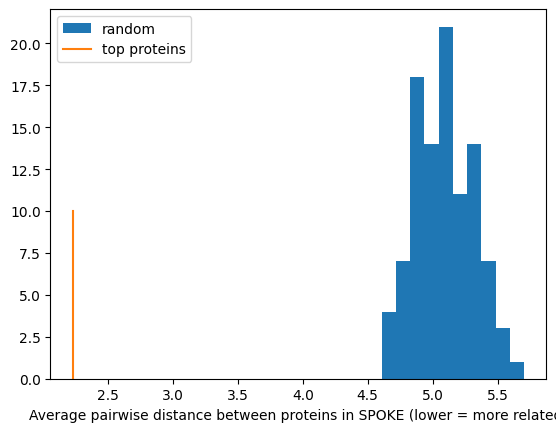

In [232]:
plt.hist(high_prots_null_results.average_pairwise_distance, bins=10, label='random')
plt.plot([high_prots_stats['average_pairwise_distance'], high_prots_stats['average_pairwise_distance']], [0, 10], label='top proteins')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.legend()

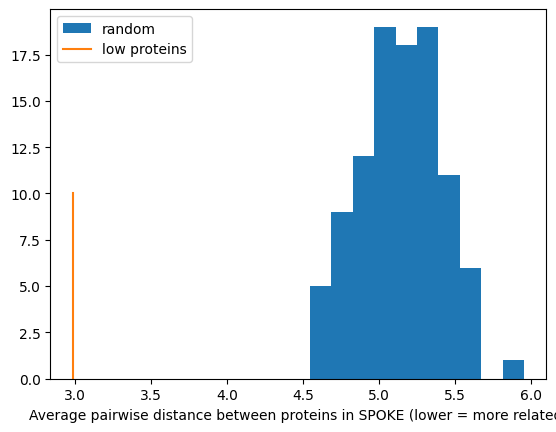

In [233]:
plt.hist(low_prots_null_results.average_pairwise_distance, bins=10, label='random')
plt.plot([low_prots_stats['average_pairwise_distance'], low_prots_stats['average_pairwise_distance']], [0, 10], label='low proteins')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.legend()

## 3. Run topic PageRank

In [21]:
high_prots_pr_results, high_prots_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, high_prots_spoke_ids)

In [22]:
low_prots_pr_results, low_prots_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, low_prots_spoke_ids)

In [23]:
high_chems_pr_results, high_chems_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, [x[1] for x in high_chems_spoke_ids])

In [24]:
low_chems_pr_results, low_chems_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, [x[1] for x in low_chems_spoke_ids])

In [25]:
high_prots_top_proteins = [x for x in high_prots_top_nodes if x['category'] == 'Protein']
high_prots_top_genes = [x for x in high_prots_top_nodes if x['category'] == 'Gene']

### Run topic pagerank on biological-only SPOKE

In [26]:
high_prots_pr_results_l1, high_prots_top_nodes_l1 = kgfe.explanations.topic_pagerank(spoke_level1_graph_ud, high_prots_spoke_ids)

In [27]:
low_prots_pr_results_l1, low_prots_top_nodes_l1 = kgfe.explanations.topic_pagerank(spoke_level1_graph_ud, low_prots_spoke_ids)

In [28]:
chembl_to_ids_l1 = kgfe.graph_info.spoke_identifiers_to_ids(spoke_level1_graph_ud, 'Compound')
high_chems_spoke_ids_l1 = [chembl_to_ids_l1[x] for x in high_chems if  x in chembl_to_ids_l1]
low_chems_spoke_ids_l1 = [chembl_to_ids_l1[x] for x in low_chems if  x in chembl_to_ids_l1]

In [29]:
high_chems_pr_results_l1, high_chems_top_nodes_l1 = kgfe.explanations.topic_pagerank(spoke_level1_graph_ud, high_chems_spoke_ids_l1)

In [30]:
low_chems_pr_results_l1, low_chems_top_nodes_l1 = kgfe.explanations.topic_pagerank(spoke_level1_graph_ud, low_chems_spoke_ids_l1)

In [31]:
high_prots_top_proteins_l1 = [x for x in high_prots_top_nodes_l1 if x['category'] == 'Protein']
high_prots_top_genes_l1 = [x for x in high_prots_top_nodes_l1 if x['category'] == 'Gene']

## 4. Plot PageRank results

In [32]:
import matplotlib.pyplot as plt

### Proteins with positive Lasso_CV scores

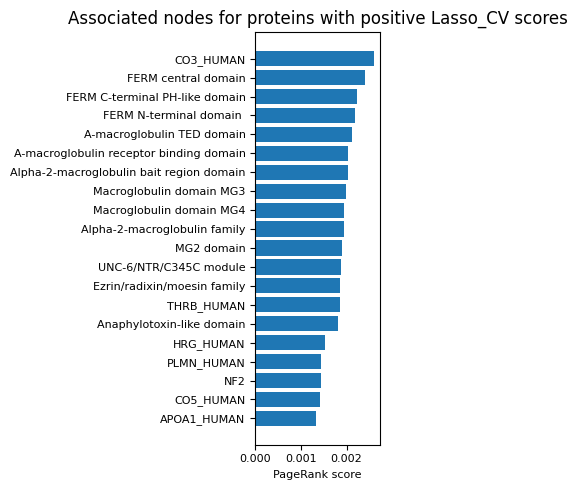

In [33]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_nodes[:20][::-1]], [x['score'] for x in high_prots_top_nodes[:20][::-1]], )
plt.title('Associated nodes for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

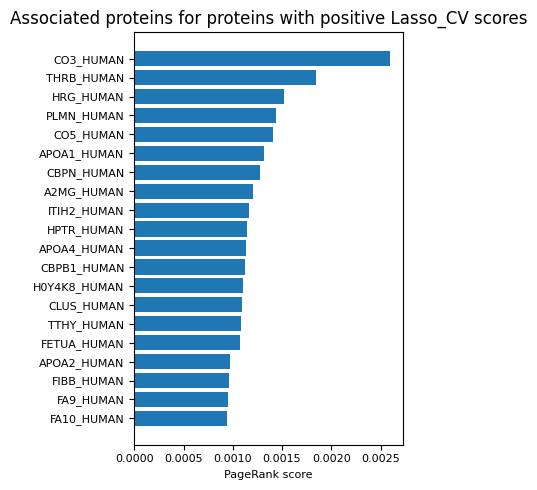

In [34]:
high_prots_top_proteins = [x for x in high_prots_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

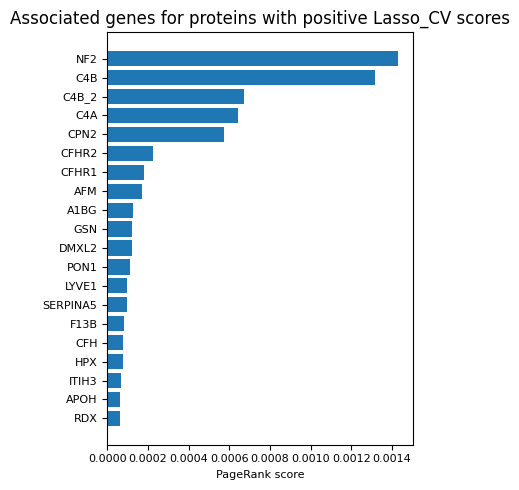

In [35]:
high_prots_top_genes = [x for x in high_prots_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_genes[:20][::-1]], [x['score'] for x in high_prots_top_genes[:20][::-1]], )
plt.title('Associated genes for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Proteins with negative Lasso_CV scores

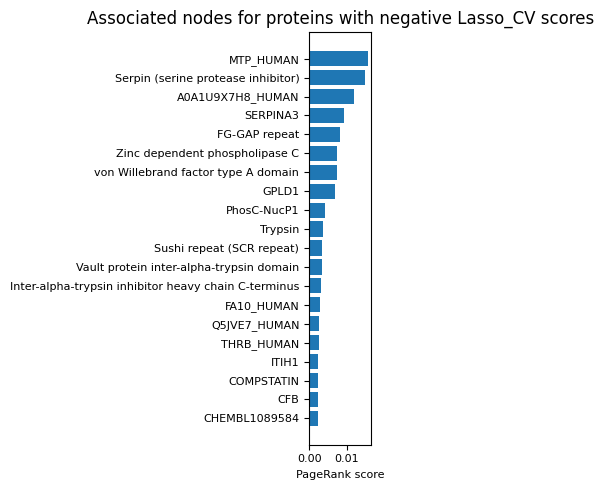

In [36]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_nodes[:20][::-1]], [x['score'] for x in low_prots_top_nodes[:20][::-1]], )
plt.title('Associated nodes for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

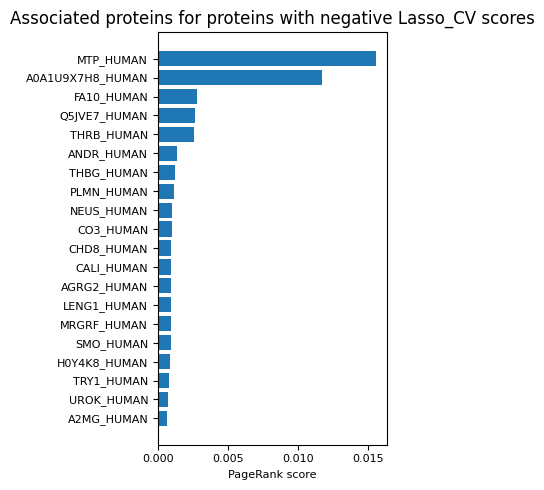

In [37]:
low_prots_top_proteins = [x for x in low_prots_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_proteins[:20][::-1]], [x['score'] for x in low_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

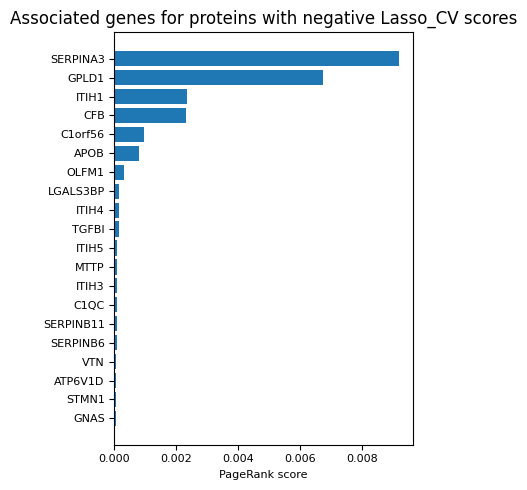

In [38]:
low_prots_top_genes = [x for x in low_prots_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_genes[:20][::-1]], [x['score'] for x in low_prots_top_genes[:20][::-1]], )
plt.title('Associated genes for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Chems with positive Lasso_CV scores

/tmp/ipykernel_420545/2546614946.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


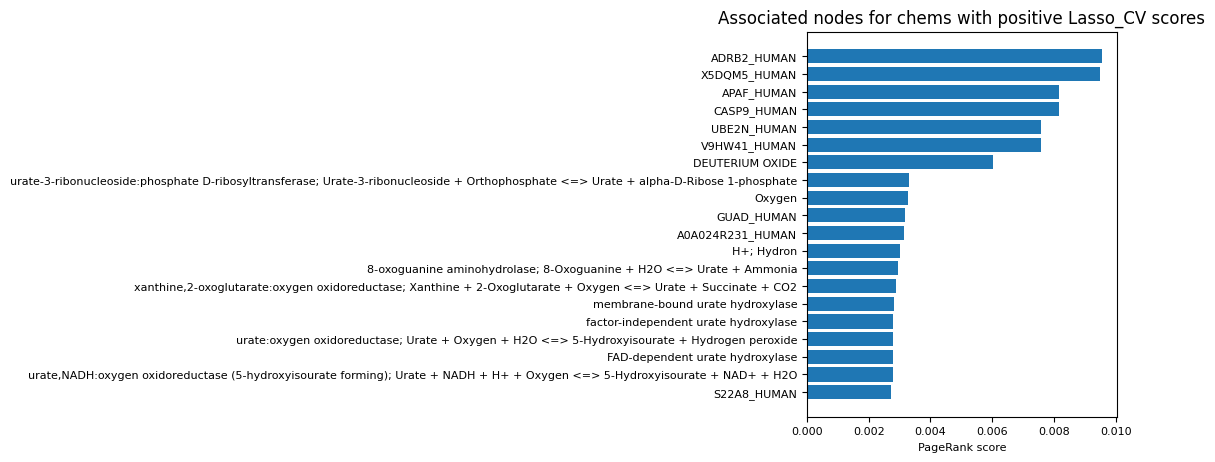

In [39]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_nodes[:20][::-1]], [x['score'] for x in high_chems_top_nodes[:20][::-1]], )
plt.title('Associated nodes for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

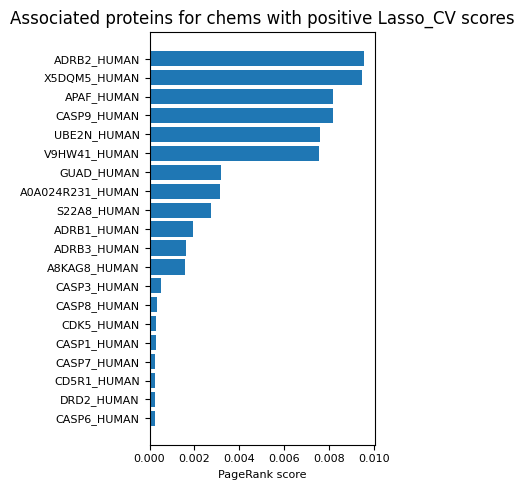

In [40]:
high_chems_top_proteins = [x for x in high_chems_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_proteins[:20][::-1]], [x['score'] for x in high_chems_top_proteins[:20][::-1]], )
plt.title('Associated proteins for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

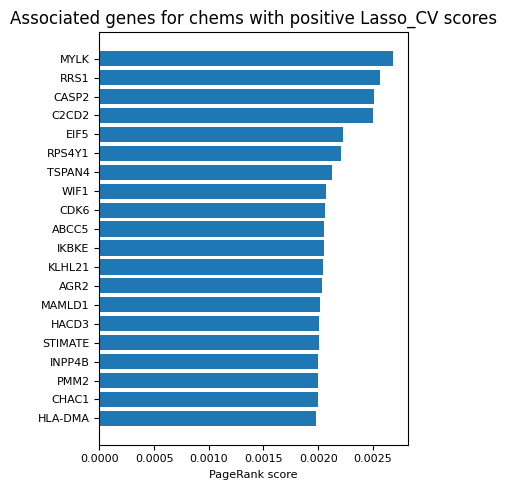

In [41]:
high_chems_top_genes = [x for x in high_chems_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_genes[:20][::-1]], [x['score'] for x in high_chems_top_genes[:20][::-1]], )
plt.title('Associated genes for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

/tmp/ipykernel_420545/1194101335.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


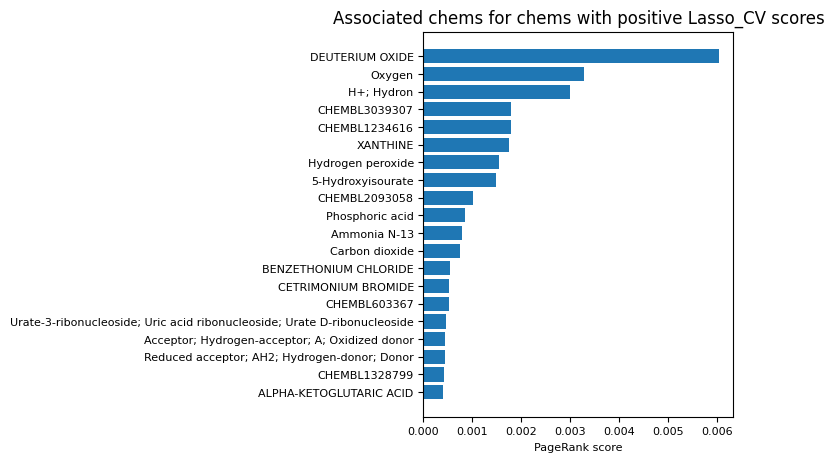

In [42]:
high_chems_top_chems = [x for x in high_chems_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_chems[:20][::-1]], [x['score'] for x in high_chems_top_chems[:20][::-1]], )
plt.title('Associated chems for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Chems with negative Lasso_CV scores

/tmp/ipykernel_420545/3090059252.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


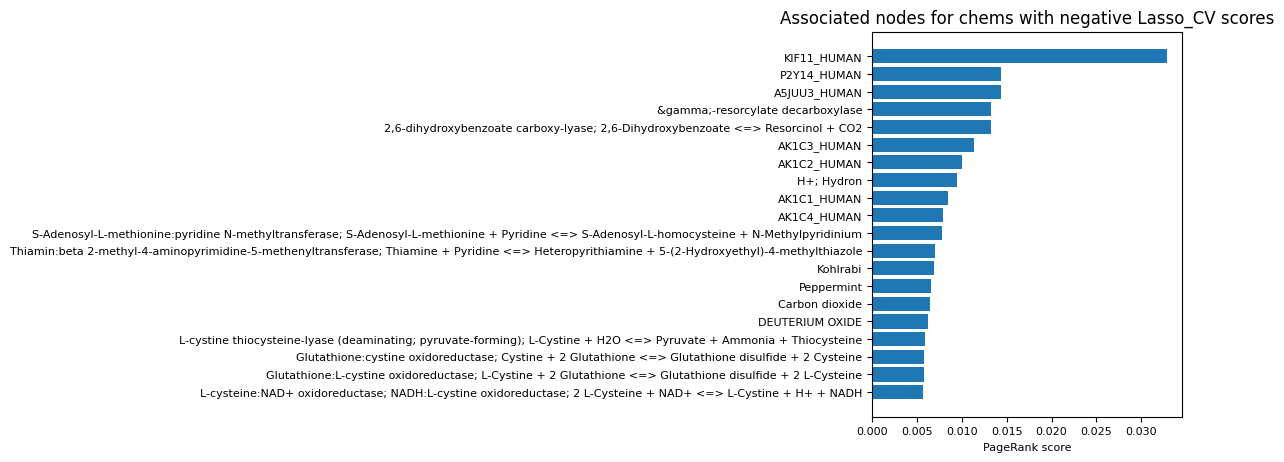

In [43]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_nodes[:20][::-1]], [x['score'] for x in low_chems_top_nodes[:20][::-1]], )
plt.title('Associated nodes for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

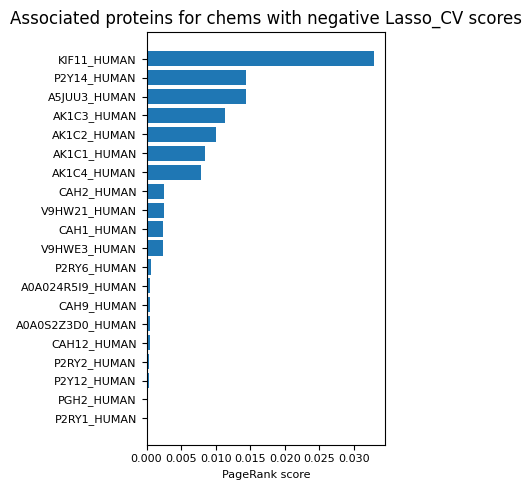

In [44]:
low_chems_top_proteins = [x for x in low_chems_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_proteins[:20][::-1]], [x['score'] for x in low_chems_top_proteins[:20][::-1]], )
plt.title('Associated proteins for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

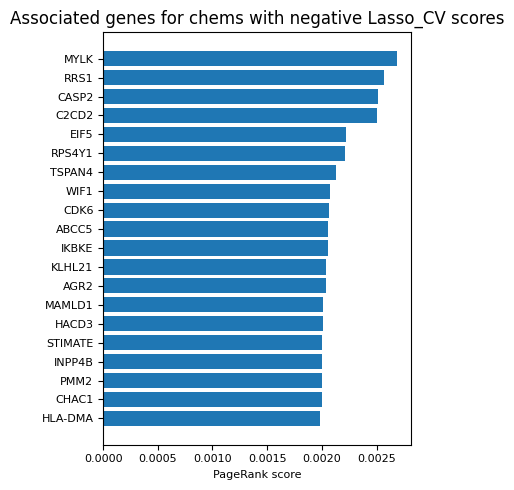

In [45]:
low_chems_top_genes = [x for x in high_chems_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_genes[:20][::-1]], [x['score'] for x in low_chems_top_genes[:20][::-1]], )
plt.title('Associated genes for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

/tmp/ipykernel_420545/1551663627.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


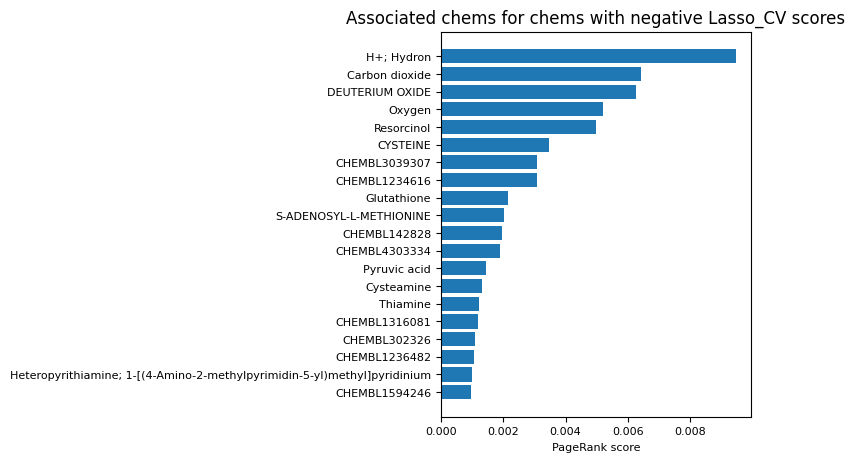

In [46]:
low_chems_top_chems = [x for x in low_chems_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_chems[:20][::-1]], [x['score'] for x in low_chems_top_chems[:20][::-1]], )
plt.title('Associated chems for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### TODO: pagerank plots for biological-only spoke

## 5. Get Steiner trees / subgraphs

In [142]:
high_protein_st, high_protein_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                                 high_prots_spoke_ids,
                                                                                 method='takahashi')

In [143]:
low_protein_st, low_protein_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                              low_prots_spoke_ids,
                                                                              method='takahashi')

In [144]:
# TODO: get a connected component from the first chem?

In [145]:
high_chems_st, high_chems_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                            [x[1] for x in high_chems_spoke_ids],
                                                                            method='takahashi')

In [146]:
low_chems_st, low_chems_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                          [x[1] for x in low_chems_spoke_ids],
                                                                          method='takahashi')

### Get steiner trees for biological-only spoke

In [147]:
high_protein_st_l1, high_protein_subgraph_l1 = kgfe.explanations.steiner_tree_subgraph(spoke_level1_graph_ud,
                                                                                 high_prots_spoke_ids,
                                                                                 method='takahashi')

In [148]:
low_protein_st_l1, low_protein_subgraph_l1 = kgfe.explanations.steiner_tree_subgraph(spoke_level1_graph_ud,
                                                                              low_prots_spoke_ids,
                                                                              method='takahashi')

In [149]:
high_chems_st_l1, high_chems_subgraph_l1 = kgfe.explanations.steiner_tree_subgraph(spoke_level1_graph_ud,
                                                                            high_chems_spoke_ids_l1,
                                                                            method='takahashi')

In [150]:
low_chems_st_l1, low_chems_subgraph_l1 = kgfe.explanations.steiner_tree_subgraph(spoke_level1_graph_ud,
                                                                          low_chems_spoke_ids_l1,
                                                                          method='takahashi')

## Visualizing subgraphs

In [56]:
import ipycytoscape

In [57]:
# TODO: display the node category somewhere, and display the edge categories
graph_style = [{
                        'selector': 'node[feature_name]',
                             'style': {
                                  'font-family': 'helvetica',
                                  'font-size': '20px',
                                 'label': 'data(feature_name)',
                        }},
                        {'selector': 'node[category="Protein"]',
                         'style': {
                             'background-color': 'blue',
                         }},
                        {'selector': 'node[in_query=1]',
                         'style': {
                             'border-width': '5px',
                             'border-color': 'red',
                         }},
                        {'selector': 'edge[type]',
                         'style': {
                             'label': 'data(type)',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                    }},

                    ]

In [195]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = high_protein_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [196]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [197]:
low_prots_graph = ipycytoscape.CytoscapeWidget()
low_protein_subgraph_nx = low_protein_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in low_protein_subgraph_nx.nodes.items()}
low_protein_subgraph_nx = nx.relabel_nodes(low_protein_subgraph_nx, node_dict)
low_prots_graph.graph.add_graph_from_networkx(low_protein_subgraph_nx)
low_prots_graph.set_tooltip_source('name')
low_prots_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_prots_graph.set_style(graph_style)

In [198]:
display(low_prots_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [199]:
high_chems_graph = ipycytoscape.CytoscapeWidget()
high_chems_subgraph_nx = high_chems_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_chems_subgraph_nx.nodes.items()}
high_chems_subgraph_nx = nx.relabel_nodes(high_chems_subgraph_nx, node_dict)
high_chems_graph.graph.add_graph_from_networkx(high_chems_subgraph_nx)
high_chems_graph.set_tooltip_source('name')
high_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
high_chems_graph.set_style(graph_style)

In [200]:
display(high_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [201]:
low_chems_graph = ipycytoscape.CytoscapeWidget()
low_chems_subgraph_nx = low_chems_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in low_chems_subgraph_nx.nodes.items()}
low_chems_subgraph_nx = nx.relabel_nodes(low_chems_subgraph_nx, node_dict)
low_chems_graph.graph.add_graph_from_networkx(low_chems_subgraph_nx)
low_chems_graph.set_tooltip_source('name')
low_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_chems_graph.set_style(graph_style)

In [202]:
display(low_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

### TODO: Visualizing subgraphs for biological-only spoke

In [203]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_l1_nx = high_protein_subgraph_l1.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_l1_nx.nodes.items()}
high_protein_subgraph_l1_nx = nx.relabel_nodes(high_protein_subgraph_l1_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_l1_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [204]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [205]:
low_prots_graph = ipycytoscape.CytoscapeWidget()
low_protein_subgraph_l1_nx = low_protein_subgraph_l1.to_networkx()
node_dict = {i: n['name'] for i, n in low_protein_subgraph_l1_nx.nodes.items()}
low_protein_subgraph_l1_nx = nx.relabel_nodes(low_protein_subgraph_l1_nx, node_dict)
low_prots_graph.graph.add_graph_from_networkx(low_protein_subgraph_l1_nx)
low_prots_graph.set_tooltip_source('name')
low_prots_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_prots_graph.set_style(graph_style)

In [206]:
display(low_prots_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [209]:
high_chems_graph = ipycytoscape.CytoscapeWidget()
high_chems_subgraph_l1_nx = high_chems_subgraph_l1.to_networkx()
node_dict = {i: n['name'] for i, n in high_chems_subgraph_l1_nx.nodes.items()}
high_chems_subgraph_l1_nx = nx.relabel_nodes(high_chems_subgraph_l1_nx, node_dict)
high_chems_graph.graph.add_graph_from_networkx(high_chems_subgraph_l1_nx)
high_chems_graph.set_tooltip_source('name')
high_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
high_chems_graph.set_style(graph_style)

In [210]:
display(high_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [211]:
low_chems_graph = ipycytoscape.CytoscapeWidget()
low_chems_subgraph_l1_nx = low_chems_subgraph_l1.to_networkx()
node_dict = {i: n['name'] for i, n in low_chems_subgraph_l1_nx.nodes.items()}
low_chems_subgraph_l1_nx = nx.relabel_nodes(low_chems_subgraph_l1_nx, node_dict)
low_chems_graph.graph.add_graph_from_networkx(low_chems_subgraph_l1_nx)
low_chems_graph.set_tooltip_source('name')
low_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_chems_graph.set_style(graph_style)

In [212]:
display(low_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…